In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as optimize

Capteur S5K2LD https://www.digchip.com/datasheets/parts/datasheet/2/409/S5K2LD.php

Resolution	4032x3024 (12M)

Pixel Size	1.8µm

Optical Format	1/1.76"

Pixel Type	ISOCELL Plus

Interface	MIPI 4 Lane RAW

Chroma	RGB

Auto Focus	Dual-PD

https://www.devicespecifications.com/en/model/30ea5488


Au lieu de mesurer les dimension de la photo en cm, on la mesure en pixels avec un logiciel photo.

Le fabricant du telephone donne aussi les dimensions en pixels (4032 x 3024) pixels (la largeur de chaque pixel est donné à 1.8 µm). Donc pour éviter d'introduire une source d'erreur supplémentaire, on choisi de mesurer nos grandeurs en pixels.

En prenant une photo quelconque, on vérifie que la photo fait bien 4032 x 3024 pixels.

On e

Incertitudes pour OA : + 1 mm / UA (incertitude règle) + 2 mm (erreur fixe, lié à la difficulté de bien placer telephone)


Marche pas que en pixels, facteur de conversion

6.45 x 8.46 mm (CMOS size)




In [12]:
ratio1 = 8.46*1e-3 / 4032 # m/px

ratio2 = 6.45*1e-3 / 3024 # m/px

print(ratio1)
print(ratio2)

ratio = (ratio1+ratio2)/2 # take average
uncert_ratio = np.abs(ratio2 - ratio) # distance between average and value is uncertainty

print(f"{ratio:.3} ± {uncert_ratio:.2}")

photo_height = 14.4 * 1e-2 # m
ratio3 = 8.46*1e-3/photo_height # m/m
print(f"{ratio3:.3} ± {uncert_ratio:.2}")

2.0982142857142857e-06
2.132936507936508e-06
2.12e-06 ± 1.7e-08
0.0587 ± 1.7e-08


étape 1, calculer $\gamma$ à partir de A'B' et AB

[0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012]
[0.00013256]
0.00664744572849756
focale expérimentale : 0.00695606199924754 ± [0.00013256] m
6.96 mm


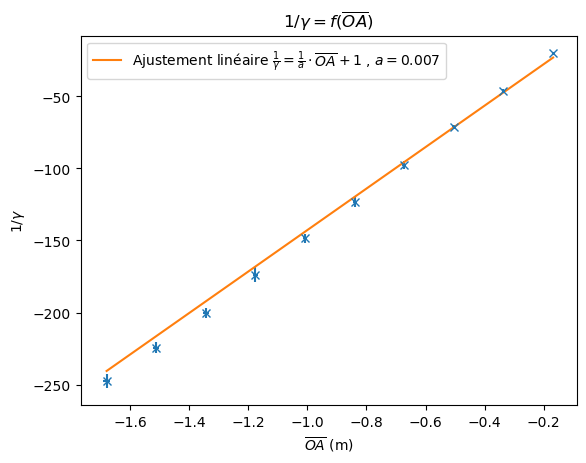

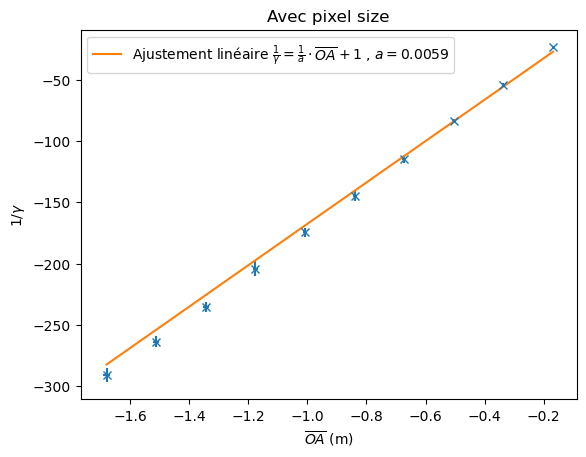

[-0.168 -0.336 -0.504 -0.672 -0.84  -1.008 -1.176 -1.344 -1.512 -1.68 ]
[0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012]


In [15]:
data = pd.read_csv("data.csv")


AO_ua = data["AO (ua)"].to_numpy(dtype=float)
ApBp_min_px = -data["B\'A\'_min (pixels)"].to_numpy(dtype=float)
ApBp_max_px = -data["B\'A\'_max (pixels)"].to_numpy(dtype=float)

ApBp_regle = -data["B\'A\'_regle (cm)"].to_numpy(dtype=float)

#eps = -10

ApBp_px = (ApBp_max_px + ApBp_min_px)/2  # A'B' (px)
uncert_ApBp_px = np.abs(ApBp_max_px) - np.abs(ApBp_px)

# we don't use this anymore
pixel_size = 1.8 * 1e-6 # m

ApBp_1 = ApBp_px * ratio
uncert_ApBp_1 = uncert_ApBp_px * ratio

ApBp_2 = ApBp_px * pixel_size
uncert_ApBp_2 = uncert_ApBp_px * pixel_size


AB = (6.1 * 1e-2)*np.ones(len(ApBp_1)) # m
uncert_AB = (0.1 * 1e-2)*np.ones(len(ApBp_1)) # m

gamma_1 = ApBp_1/AB

gamma_inv_1 = 1/gamma_1
uncert_gamma_inv_1 = np.sqrt( (1/ApBp_1 * uncert_AB)**2 + (AB/(ApBp_1**2) * uncert_ApBp_1)**2 )

gamma_2 = ApBp_2/AB

gamma_inv_2 = 1/gamma_2
uncert_gamma_inv_2 = np.sqrt( (1/ApBp_2 * uncert_AB)**2 + (AB/(ApBp_2**2) * uncert_ApBp_2)**2 )


ua = (15 + 1.8) * 1e-2 # m (longeur de la règle)

OA = -AO_ua * ua # m
uncert_OA = (AO_ua * 1 + 2)  *1e-3 # m


print(uncert_OA)
plt.errorbar(OA, gamma_inv_1, fmt="x", xerr=uncert_OA, yerr=uncert_gamma_inv_1)


def lin_model(x, a):
    return (1/a)*x + 1

# on néglige l'erreur sur $OA$
popt, pcov = optimize.curve_fit(lin_model, OA, gamma_inv_1, sigma=uncert_gamma_inv_1)
a_1 = popt[0]


perr_1 = np.sqrt(np.diag(pcov)) # fit error
print(perr_1)
uncert_a_1 = perr_1[0]

plt.plot(OA, lin_model(OA, a_1), label=r"Ajustement linéaire $\frac{1}{\gamma} = \frac{1}{a}\cdot \overline{OA} + 1$"+f" , $a={a_1:.2}$")

f_inv = (gamma_inv_1[-1]-gamma_inv_1[0])/(OA[-1]-OA[0])
print(1/f_inv)


print(f"focale expérimentale : {a_1} ± {uncert_a_1} m")

#plt.plot(OA, (1/(4.3*1e-3)*OA + np.ones(len(OA))))


plt.ylabel(r"$1/\gamma$")
plt.xlabel("$\overline{OA}$ (m)")

# avec ratio
print(f"{a_1*1e3:.3} mm")
plt.legend()
plt.title("$1/\gamma = f(\overline{OA})$")
#plt.savefig("gamma_inv=fOA.png", dpi=200)
plt.show()


popt2, pcov2 = optimize.curve_fit(lin_model, OA, gamma_inv_2, sigma=uncert_gamma_inv_2)
a_2 = popt2[0]

plt.errorbar(OA, gamma_inv_2, fmt="x", xerr=uncert_OA, yerr=uncert_gamma_inv_2)
plt.plot(OA, lin_model(OA, a_2), label=r"Ajustement linéaire $\frac{1}{\gamma} = \frac{1}{a}\cdot \overline{OA} + 1$"+f" , $a={a_2:.2}$")
plt.ylabel(r"$1/\gamma$")
plt.xlabel("$\overline{OA}$ (m)")
plt.legend()
plt.title("Avec pixel size")
plt.show()

print(OA)
print(uncert_OA)

In [7]:
print("| OA (cm) | A'B' (px) | A'B' (cm) | 1/gamma ")
for i in range(len(AB)):
    print(f"| {OA[i]*1e2:.3} ± {uncert_OA[i]*1e2:.2} | {ApBp_px[i]:.3} ± {uncert_ApBp_px[i]:.2} | {ApBp_1[i]*1e3:.3} ± {uncert_ApBp_1[i]*1e3:.2} | {gamma_inv_1[i]:.3} ± {uncert_gamma_inv_1[i]:.2} |")

| OA (cm) | A'B' (px) | A'B' (cm) | 1/gamma 
| -16.8 ± 0.3 | -1.44e+03 ± 1.8e+01 | -3.04 ± 0.039 | -20.0 ± 0.42 |
| -33.6 ± 0.4 | -6.23e+02 ± 1.2e+01 | -1.32 ± 0.025 | -46.3 ± 1.2 |
| -50.4 ± 0.5 | -4.06e+02 ± 4.0 | -0.859 ± 0.0085 | -71.0 ± 1.4 |
| -67.2 ± 0.6 | -2.96e+02 ± 6.5 | -0.625 ± 0.014 | -97.6 ± 2.7 |
| -84.0 ± 0.7 | -2.34e+02 ± 6.0 | -0.495 ± 0.013 | -1.23e+02 ± 3.8 |
| -1.01e+02 ± 0.8 | -1.94e+02 ± 2.0 | -0.41 ± 0.0042 | -1.49e+02 ± 2.9 |
| -1.18e+02 ± 0.9 | -1.66e+02 ± 4.0 | -0.351 ± 0.0085 | -1.74e+02 ± 5.1 |
| -1.34e+02 ± 1.0 | -1.44e+02 ± 1.0 | -0.305 ± 0.0021 | -2e+02 ± 3.6 |
| -1.51e+02 ± 1.1 | -1.28e+02 ± 0.5 | -0.272 ± 0.0011 | -2.24e+02 ± 3.8 |
| -1.68e+02 ± 1.2 | -1.16e+02 ± 1.5 | -0.246 ± 0.0032 | -2.48e+02 ± 5.2 |
